# Comparison with Partial Dependence Plot

In the "Interpretable Machine Learning" book, we [can read](https://christophm.github.io/interpretable-ml-book/pdp.html):

> The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (Friedman, Jerome H. “Greedy function approximation: A gradient boosting machine.” Annals of statistics (2001): 1189-1232.). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship.

Put differently further in the book:

> **Partial Dependence Plots:** “Let me show you what the model predicts on average when each data instance has the value v for that feature. I ignore whether the value v makes sense for all data instances.”

PDPs are used in Google's [What-If Tool](https://pair-code.github.io/what-if-tool/walkthrough.html). In this notebook, we compare this method with ours on the "Adult" dataset (see the dedicated notebook for additional information).

In [22]:
import ethik
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection
import sklearn.inspection

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
names = [
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country',
    'salary'
]
dtypes = {
    'workclass': 'category',
    'education': 'category',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'gender': 'category',
    'native-country': 'category'
}

X = pd.read_csv(url, names=names, header=None, dtype=dtypes)
y = X.pop('salary').map({' <=50K': False, ' >50K': True})

# plot_partial_dependence() doesn't handle strings
cat_columns = X.select_dtypes(['category']).columns
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, shuffle=True, random_state=42)

model = lgb.LGBMClassifier(random_state=42).fit(X_train, y_train)
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], name='>$50k')

explainer = ethik.Explainer()

Let's define helpers to compare PDP and `ethik`:

In [25]:
def plot_partial_dependence(features):
    sklearn.inspection.plot_partial_dependence(
        estimator=model,
        X=X_test,
        features=[features],
        feature_names=list(X_test.columns),
        fig=plt.figure(figsize=(12, 8), dpi=80),
        grid_resolution=41,
    )

def plot_bias(features):
    explainer.plot_bias(
        X_test=X_test[features],
        y_pred=y_pred,
        inline=True
    )

def plot_all(features):
    plot_partial_dependence(features)
    plot_bias(features)

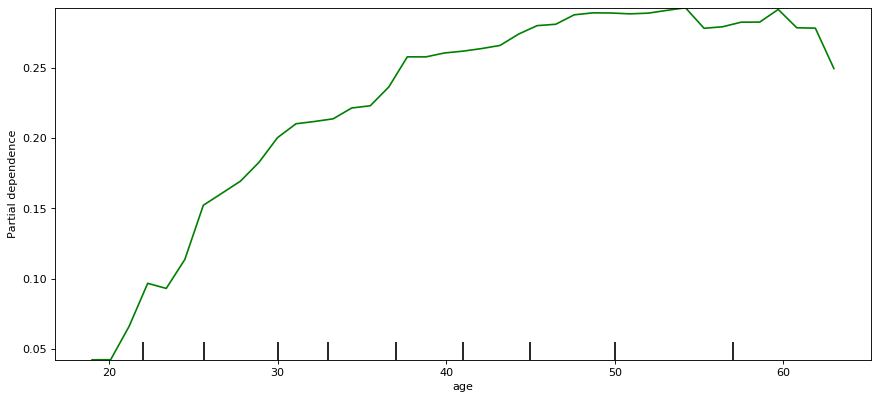

In [26]:
plot_all("age")

For `feature = x`, the corresponding y value is the average prediction of the model with all the samples having their `feature` set to `x`.

For instance, we can see that when we set the age of all individuals to 50, the average probability of earning more than $50k a year is about 30%. Of course, this is an average and some individuals are more likely to be "rich" than that (e.g. the ones who have higher education levels).

Let's compare with `ethik`: